# 04c - Vertex AI - AutoML for Global Forecasting with Deep Learning - with Python client (code)

A newer way to fit forecast models to time series data is by using a deep learning approach with neural networks. This approah can have added success because it is a global forecast, it not only sees and individual time series but also sees across many time series and can learn together from correlation.  This approach can also include covariate features that may only be known in the past or may also be available at forecast time. Vertex AI AutoML forecasting will do automatic feature engineering, model architecture search and hyperparameter tuning specific to time series data.  This method using a set of data between the training data and the test data called validation data to time series specific approachs using deep learning architectures.  

**In this notebook, the Vertex AI Python Client is used to automate the process of using Vertex AI AutoML Forecasting with interactive code.**  The best part, is all the test data will be forecasted and written back to BigQuery where we will review it, visualize it, and calcualte custom metrics to make fair comparison to other methods explored in this notebook series (`04`).

### Prerequisites:
- 04 - Time Series Forecasting - Data Review in BigQuery

### Overview:
- Setup
- Create Dataset
- Train Forecasting Model with AutoML
    - Create AutoML Forecasting Job
    - Run AutoML Forecasting Job
- Results
    - Retrieve Test Data
    - Review Custom Metrics with SQL
    - Retrieve the Forecasting Data (raw series)
    - Visualize the Time Series with Forecast

### Resources:
- [Train an AutoML model (Vertex AI API)](https://cloud.google.com/vertex-ai/docs/training/automl-api#forecasting)
- [Vertex AI Forecast: An Overview](https://cloud.google.com/blog/topics/developers-practitioners/vertex-forecast-overview)
- [Optimization objectives for tabular AutoML models](https://cloud.google.com/vertex-ai/docs/training/tabular-opt-obj#forecasting)
- [Evaluation metrics returned by Vertex AI](https://cloud.google.com/vertex-ai/docs/training/evaluating-automl-models#evaluation_metrics_returned_by)

---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/04c_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/04c_console.png">

---
## Setup

inputs:

In [23]:
PROJECT_ID='statmike-demo3'
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04c'

packages:

In [24]:
from google.cloud import bigquery
from google.cloud import aiplatform

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

clients:

In [25]:
bigquery = bigquery.Client()
aiplatform.init(project=PROJECT_ID, location=REGION)

---
## Create Dataset (Link to BigQuery Table)

Reference for [`aiplatform.TimeSeriesDataset.create`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.TimeSeriesDataset.create)

In [28]:
dataset = aiplatform.TimeSeriesDataset.create(
    display_name = f'{NOTEBOOK}_{DATANAME}', 
    bq_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.datasets.dataset:Creating TimeSeriesDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create TimeSeriesDataset backing LRO: projects/715288179162/locations/us-central1/datasets/2757130959764586496/operations/3931275856286056448
INFO:google.cloud.aiplatform.datasets.dataset:TimeSeriesDataset created. Resource name: projects/715288179162/locations/us-central1/datasets/2757130959764586496
INFO:google.cloud.aiplatform.datasets.dataset:To use this TimeSeriesDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TimeSeriesDataset('projects/715288179162/locations/us-central1/datasets/2757130959764586496')


In [29]:
#dataset = aiplatform.TimeSeriesDataset('projects/715288179162/locations/us-central1/datasets/2757130959764586496')

---
## Train Forecasting Model with AutoML

### Create AutoML Forecasting Job

Reference for [`aiplatform.AutoMLForecastingTrainingJob`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLForecastingTrainingJob)

In [30]:
dataset.column_names

['start_station_name', 'num_trips', 'splits', 'date']

In [31]:
column_specs = list(set(dataset.column_names) - set(['splits','start_station_name']))
column_specs = dict.fromkeys(column_specs, 'auto')
column_specs

{'num_trips': 'auto', 'date': 'auto'}

In [21]:
forecast_job = aiplatform.AutoMLForecastingTrainingJob(
    display_name = f'{NOTEBOOK}_{DATANAME}',
    optimization_objective = "minimize-rmse",
    column_specs = column_specs,
    labels = {'notebook':f'{NOTEBOOK}'}
)

### Run AutoML Forecasting Job

Reference for [`aiplatform.AutoMLForecastingTrainingJob.run`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLForecastingTrainingJob.run)

In [22]:
forecast = forecast_job.run(
    dataset = dataset,
    target_column = "num_trips",
    time_column = "date",
    time_series_identifier_column = "start_station_name",
    unavailable_at_forecast_columns = ["num_trips",],
    available_at_forecast_columns = ["date",],
    forecast_horizon = 14,
    data_granularity_unit = "day",
    data_granularity_count = 1,
    predefined_split_column_name = "splits",
    context_window = 28,
    export_evaluated_data_items = True,
    export_evaluated_data_items_bigquery_destination_uri = f"bq://{PROJECT_ID}:{DATANAME}:{NOTEBOOK}_automl",
    validation_options = "fail-pipeline",
    budget_milli_node_hours = 1000,
    model_display_name = f"{NOTEBOOK}_{DATANAME}_{TIMESTAMP}",
    model_labels = {'notebook':f'{NOTEBOOK}'},
    sync = False
)

INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/879337173092925440?project=715288179162
INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/715288179162/locations/us-central1/trainingPipelines/879337173092925440 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/715288179162/locations/us-central1/trainingPipelines/879337173092925440 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/715288179162/locations/us-central1/trainingPipelines/879337173092925440 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/715288179162/locations/us-central1/trainingPipelines/879337173092925440 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:g

---
## Results

### Retrieve Test Data

In [32]:
query = f"""
WITH
    RAW AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predicted_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl`
    ),
    LEAD AS (
        SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
        FROM RAW
    ),
    LEFTSIDE AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD
        GROUP BY start_station_name, date
    )
SELECT *
FROM LEFTSIDE
LEFT OUTER JOIN LEAD
USING (start_station_name, date, prediction_lead_days)
"""
autoML = bigquery.query(query = query).to_dataframe()
autoML

,start_station_name,date,prediction_lead_days,predicted_on_date,num_trips,splits,predicted_num_trips
0,Central Park S & 6 Ave,2016-09-17,0,2016-09-17,607,TEST,458.756653
1,Central Park W & W 96 St,2016-09-17,0,2016-09-17,153,TEST,127.670715
2,Central Park West & W 68 St,2016-09-17,0,2016-09-17,251,TEST,209.350815
3,Central Park West & W 72 St,2016-09-17,0,2016-09-17,264,TEST,277.735565
4,Central Park West & W 76 St,2016-09-17,0,2016-09-17,177,TEST,140.119659
...,...,...,...,...,...,...,...
154,Central Park West & W 100 St,2016-09-30,0,2016-09-30,13,TEST,39.942554
155,Central Park West & W 102 St,2016-09-30,0,2016-09-30,10,TEST,49.721699
156,W 106 St & Central Park West,2016-09-30,0,2016-09-30,32,TEST,62.499966
157,Grand Army Plaza & Central Park S,2016-09-30,0,2016-09-30,43,TEST,233.944016


### Review Custom Metrics with SQL

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divide by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$


It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [33]:
query = f"""
WITH
    FORECASTS AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predicted_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl`
    ),
    LEAD_DAYS AS (
        SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
        FROM FORECASTS
    ),
    LATEST AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD_DAYS
        GROUP BY start_station_name, date
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM LATEST
        LEFT OUTER JOIN LEAD_DAYS
        USING (start_station_name, date, prediction_lead_days)    
    )
SELECT start_station_name, time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE
FROM DIFFS
GROUP BY start_station_name, time_series_type
ORDER BY start_station_name, time_series_type    
"""
customMetrics = bigquery.query(query = query).to_dataframe()
customMetrics

,start_station_name,time_series_type,MAPE,MAE,pMAE
0,Central Park North & Adam Clayton Powell Blvd,forecast,0.769528,55.339293,0.356535
1,Central Park S & 6 Ave,forecast,0.627904,93.935824,0.287831
2,Central Park W & W 96 St,forecast,0.615351,24.213984,0.241967
3,Central Park West & W 100 St,forecast,1.006627,16.220531,0.409167
4,Central Park West & W 102 St,forecast,0.518066,11.903496,0.235048
5,Central Park West & W 68 St,forecast,0.485195,44.847782,0.296025
6,Central Park West & W 72 St,forecast,0.675453,54.832064,0.309920
7,Central Park West & W 76 St,forecast,0.349251,25.036097,0.228640
8,Central Park West & W 85 St,forecast,1.091491,50.504378,0.401739
9,Grand Army Plaza & Central Park S,forecast,0.603657,64.797690,0.297973


Overall Metrics:

In [34]:
query = f"""
WITH
    FORECASTS AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predicted_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl`
    ),
    LEAD_DAYS AS (
        SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
        FROM FORECASTS
    ),
    LATEST AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD_DAYS
        GROUP BY start_station_name, date
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM LATEST
        LEFT OUTER JOIN LEAD_DAYS
        USING (start_station_name, date, prediction_lead_days)    
    )
SELECT time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE
FROM DIFFS
GROUP BY time_series_type
ORDER BY time_series_type    
"""
customMetricsOverall = bigquery.query(query = query).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE
0,forecast,0.598523,39.742382,0.296738


### Retrieve the Forecasting Data (raw series)

In [35]:
query = f"""
SELECT start_station_name, date, splits, num_trips
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
ORDER by start_station_name, date
"""
rawSeries = bigquery.query(query = query).to_dataframe()

Retrieve key dates for visualization:

In [36]:
query = f"""
WITH
    SPLIT AS (
        SELECT splits, min(date) as mindate, max(date) as maxdate
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        GROUP BY splits
    ),
    TRAIN AS (
        SELECT mindate as start_date
        FROM SPLIT
        WHERE splits ='TRAIN'
    ),
    VAL AS (
        SELECT mindate as val_start
        FROM SPLIT
        WHERE splits = 'VALIDATE'
    ),
    TEST AS (
        SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, DAY)+1 as forecast_horizon
        FROM SPLIT
        WHERE splits = 'TEST'
    )
SELECT * EXCEPT(pos) FROM
(SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
USING (pos)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
USING (pos)
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date,forecast_horizon
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30,14


### Visualize The Time Series with Forecast

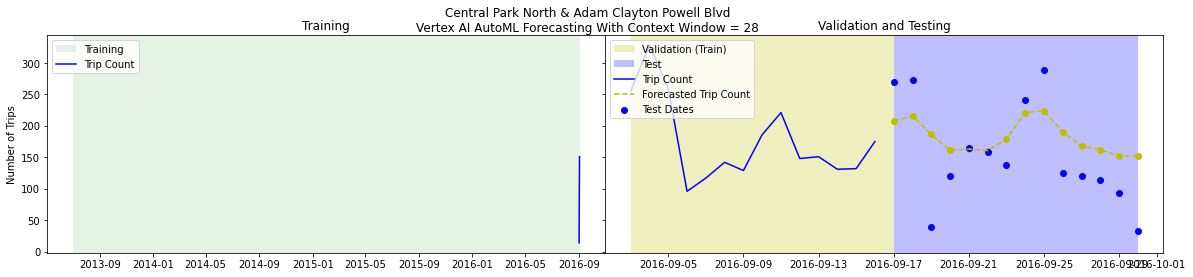

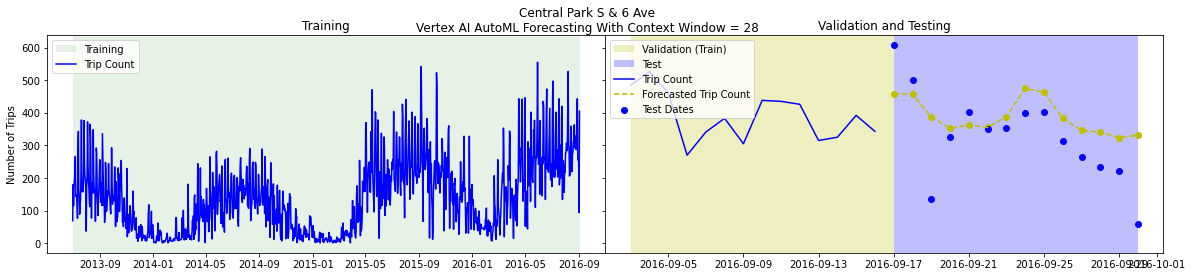

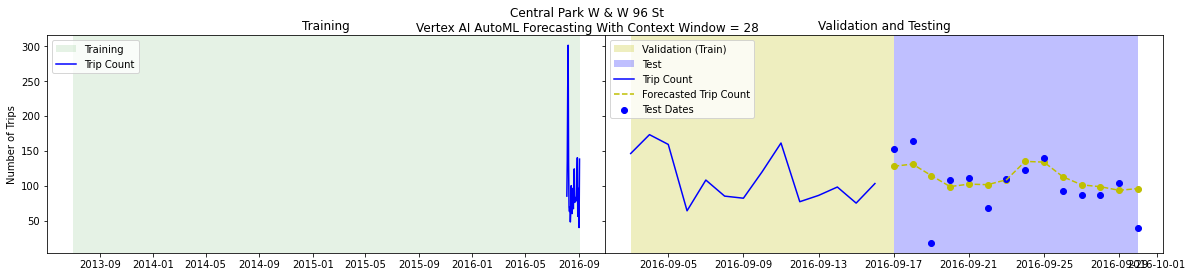

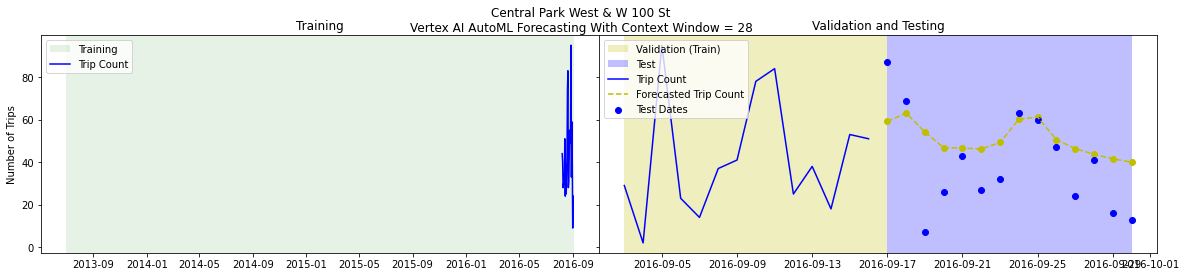

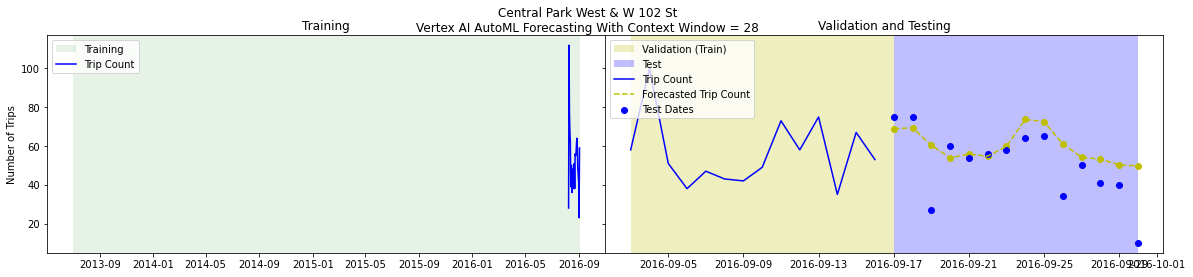

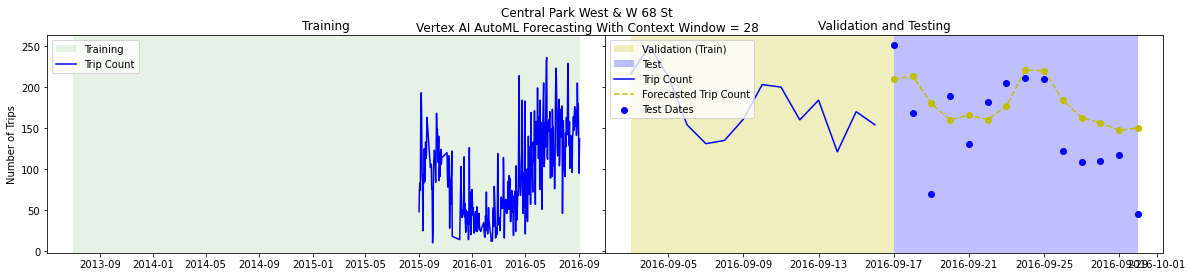

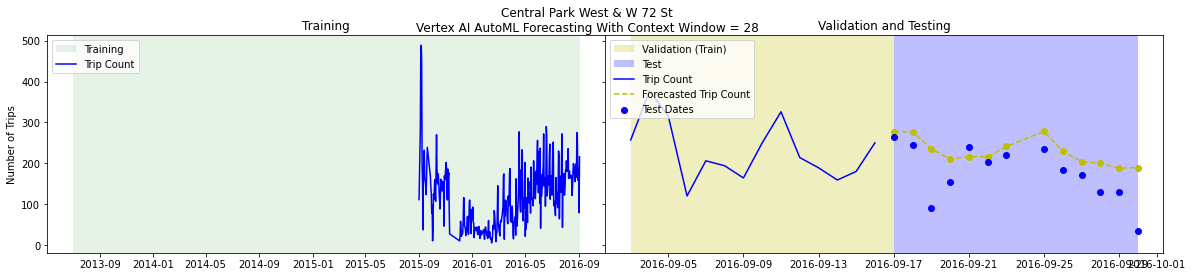

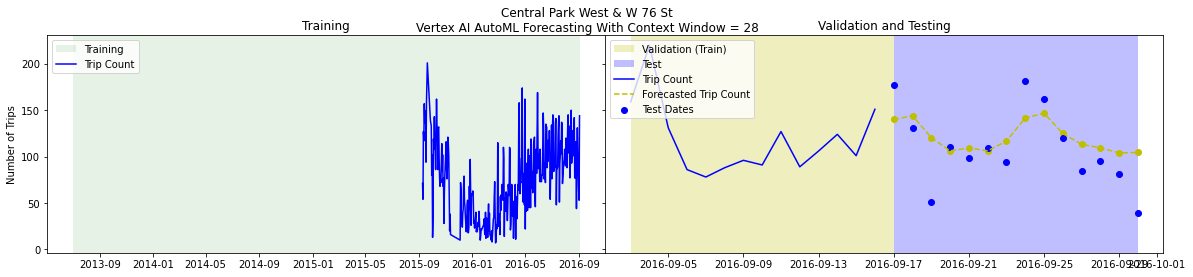

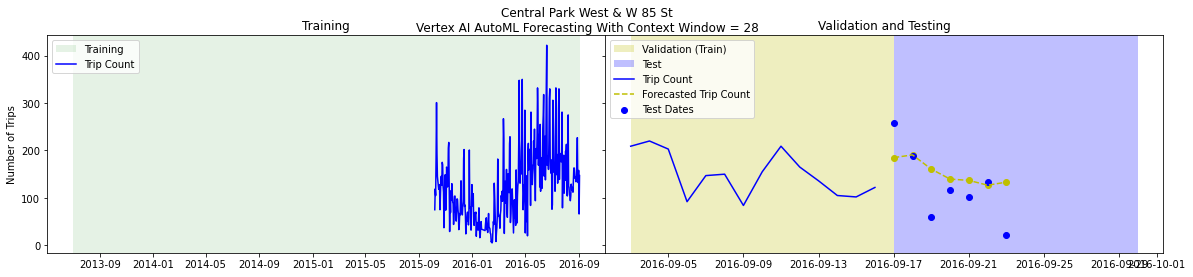

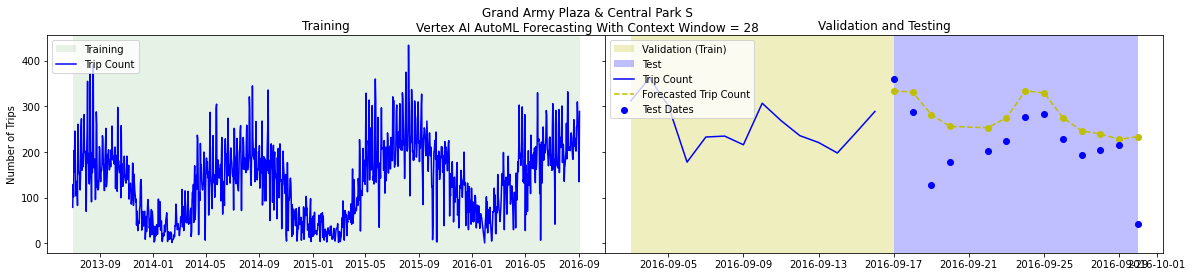

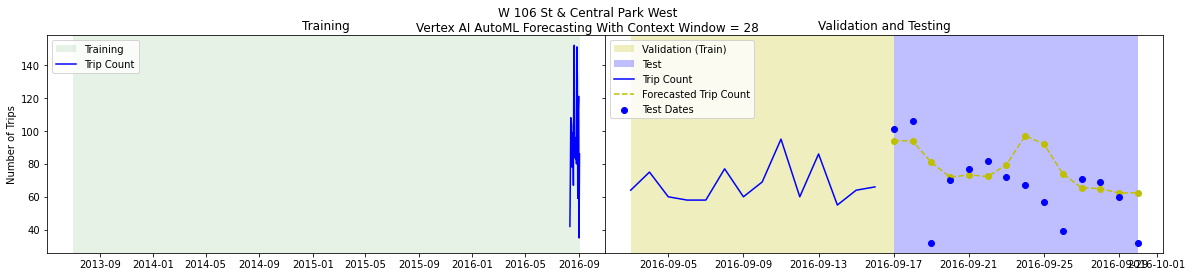

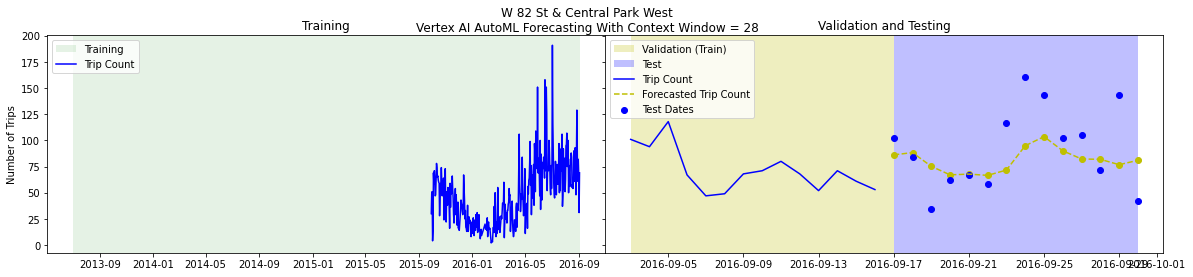

In [37]:
stations = rawSeries['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TEST')]
    fit_testdf = autoML[(autoML['start_station_name'] == st) & (autoML['splits'] == 'TEST')]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    #axes[1].plot(testdf['date'], testdf['num_trips'], color = 'b')
    
    axes[1].plot(fit_testdf['date'], fit_testdf['predicted_num_trips'], color = 'y', label = 'Forecasted Trip Count', linestyle='dashed')
    axes[1].scatter(fit_testdf['date'], fit_testdf['predicted_num_trips'], color = 'y')
    
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Test Dates')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st + f"\nVertex AI AutoML Forecasting With Context Window = 28")

    # display result
    plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"